## 作業
礙於不是所有同學都有 GPU ，這邊的範例使用的是簡化版本的 ResNet，確保所有同學都能夠順利訓練!


最後一天的作業請閱讀這篇非常詳盡的[文章](https://blog.gtwang.org/programming/keras-resnet-50-pre-trained-model-build-dogs-cats-image-classification-system/)，基本上已經涵蓋了所有訓練　CNN 常用的技巧，請使用所有學過的訓練技巧，盡可能地提高 Cifar-10 的 test data 準確率，截圖你最佳的結果並上傳來完成最後一次的作業吧!

另外這些技巧在 Kaggle 上也會被許多人使用，更有人會開發一些新的技巧，例如使把預訓練在 ImageNet 上的模型當成 feature extractor 後，再拿擷取出的特徵重新訓練新的模型，這些技巧再進階的課程我們會在提到，有興趣的同學也可以[參考](https://www.kaggle.com/insaff/img-feature-extraction-with-pretrained-resnet)

In [1]:
import tensorflow as tf
import numpy as np
import os

import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10


Using TensorFlow backend.


In [0]:
batch_size = 128
epochs = 200
data_augmentation = True
num_classes = 10
subtract_pixel_mean = True
n = 9
version = 1
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2
model_type = 'ResNet%dv%d' % (depth, version) # 'ResNet56v1'

In [0]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
input_shape = x_train.shape[1:] # (32, 32, 3)

In [0]:
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

In [0]:
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis = 0)
    x_train -= x_train_mean
    x_test -= x_train_mean # 測試資料也是減去訓練資料的平均值


In [19]:
print(x_train.shape)
print(x_train.shape[0])
print(x_test.shape)
print(y_train.shape)

(50000, 32, 32, 3)
50000
(10000, 32, 32, 3)
(50000, 1)


In [0]:
# one-hot encoding
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [0]:
def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 120:
        lr *= 1e-3
    elif epoch > 80:
        lr *= 1e-2
    elif epoch > 50:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [0]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x    

In [0]:
def resnet_v1(input_shape, depth, num_classes=10):
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model    

In [0]:
def resnet_v1(input_shape, depth, num_classes=10):
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2')
    num_filters = 16
    num_res_blocks = int((depth -2) / 6)

    inputs = Input(shape=input_shape) # input layer
    x = resnet_layer(inputs=inputs) # first cnn

    # build 3 stage
    for stack in range(3):
        # build n residual blocks for each stage
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0: # first layer but not first stack
                strides = 2 # downsample
            y = resnet_layer(inputs=x, num_filters=num_filters,strides=strides)
            y = resnet_layer(inputs=y, num_filters=num_filters, activation=None)

            if stack > 0 and res_block == 0:
                x = resnet_layer(inputs=x, num_filters=num_filters,kernel_size=1,
                                 strides=strides, activation=None, batch_normalization=False)
            x = keras.layers.add([x,y]) # 把 featuremaps 與 上一層的輸入加起來
            x = Activation('relu')(x)
        num_filters *= 2

    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)

    outputs = Dense(num_classes, activation='softmax', kernel_initializer='he_normal')(y)

    # build model
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [0]:
# build ResNet v1/v2 model
if version == 1:
    model = resnet_v1(input_shape=input_shape, depth=depth)
elif versioin == 2:
    model = resnet_v2(input_shape=input_shape, depth=depth)

# compile model, optimizer is Adam
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=lr_schedule(0)), metrics=['accuracy'])
model.summary()
print(model_type)

save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

filepath = os.path.join(save_dir, model_name)

checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

# dynamic learning rate
lr_schedule = LearningRateScheduler(lr_schedule)

# 使用自動降低學習率 (當 validation loss 連續 5 次沒有下降時，自動降低學習率)
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_schedule]

In [56]:
if not data_augmentation:
    print('Not using data augmentation')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                        validation_data=(x_test, y_test),
                        epochs=epochs, verbose=1, workers=4,
                        callbacks=callbacks)    

Using real-time data augmentation.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/200
Learning rate:  0.001
391/391 [==============================] - 83s 213ms/step - loss: 1.9786 - acc: 0.4368 - val_loss: 2.2139 - val_acc: 0.4343

Epoch 00001: val_acc improved from -inf to 0.43430, saving model to /content/saved_models/cifar10_ResNet56v1_model.001.h5
Epoch 2/200
Learning rate:  0.001
391/391 [==============================] - 44s 112ms/step - loss: 1.5397 - acc: 0.5912 - val_loss: 1.9771 - val_acc: 0.5051

Epoch 00002: val_acc improved from 0.43430 to 0.50510, saving model to /content/saved_models/cifar10_ResNet56v1_model.002.h5
Epoch 3/200
Learning rate:  0.001
391/391 [==============================] - 43s 111ms/step - loss: 1.3177 - acc: 0.6630 - val_loss: 1.4815 - val_acc: 0.6167

Epoch 00003: val_acc improved from 0.50510 to 0.61670, saving model to /content/saved_models/cifar10_ResNet56v1_model.003.h5
Epoch 4/200
Learning

In [57]:
# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

10000/10000 [==============================] - 4s 373us/step
Test loss: 0.5181151487350464
Test accuracy: 0.9231


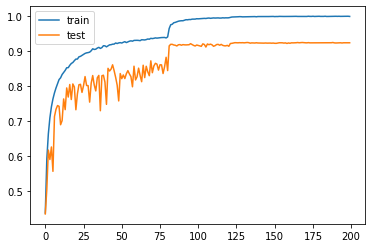

In [63]:
import matplotlib.pyplot as plt
%matplotlib inline
train_acc = model.history.history['acc']
test_acc = model.history.history['val_acc']

plt.plot(train_acc, label='train')
plt.plot(test_acc, label='test')
plt.legend()
plt.show()

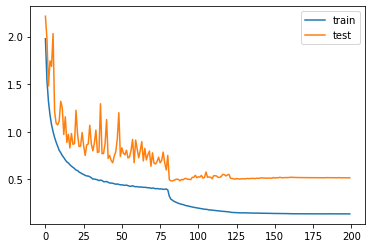

In [64]:
train_loss = model.history.history['loss']
test_loss = model.history.history['val_loss']

plt.plot(train_loss, label='train')
plt.plot(test_loss, label='test')
plt.legend()
plt.show()